# Single Server Example to show Metastability

In [1]:
# IMPORTANT: THE PATH IS CURRENTLY HARDCODED. CHANGE IT TO POINT TO YOUR LOCAL COPY OF `metafor`
import os, sys
sys.path.append("/Users/rupak/Code/metafor")
sys.path.append("/Users/rupak/Code/metafor/metafor")
sys.path.append(".")

In [2]:
import math
import numpy as np
from numpy import linspace
import pandas
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from metafor.dsl.dsl import Server, Work, Source, Program
from metafor.model.single_server.ctmc import SingleServerCTMC


## Defining the program

In [20]:


def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=1000, orbit_size=3, thread_pool=100)
        src = Source('client', 'insert', 6200, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

def basic_stats(p: Program):
        p.print()
        print("Building CTMC")
        ctmc: SingleServerCTMC = p.build()
        print("Computing stationary distribution")
        pi = ctmc.get_stationary_distribution()
        print("Average queue size = ", ctmc.main_queue_size_average(pi))
        print("Mixing time = ", ctmc.get_mixing_time())
        # S1 = ctmc.set_construction([[0, int(.3*ctmc.main_queue_size)]], [[0, ctmc.retry_queue_size]])
        # S2 = ctmc.set_construction([[int(.9*ctmc.main_queue_size), ctmc.main_queue_size]], [[0, ctmc.retry_queue_size]])
        S1 = ctmc.set_construction([[0, int( 0.5 * ctmc.main_queue_size) ]], [[0, ctmc.retry_queue_size-1]])
        S2 = ctmc.set_construction([[int(0.95 * ctmc.main_queue_size), ctmc.main_queue_size-1]], [[0, ctmc.retry_queue_size-1]])
        ht_su = ctmc.get_hitting_time_average(S1, S2)
        ht_us = ctmc.get_hitting_time_average(S2, S1)
        print("Expected hitting time to go from high to low mode is", ht_us)
        print("Expected hitting time to go from low to high mode is", ht_su)

In [4]:
p = program()
basic_stats(p)

Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 1000 orbit 3 threads 100]
Sources:  	 client: generates insert: (arr 6200.000000, to 3, re 4)
Building CTMC
Program:  Service52 , Number of states =  3000
Computing stationary distribution
Average queue size =  [210.8810831]
[-24900.49434821+0.j -24900.26923264+0.j -24900.158918  +0.j ...
  -3578.40421458+0.j  -4048.25060257+0.j  -3291.36503831+0.j]
Sorted eigenvalues (real parts): [-2.65195643e-11 -1.74183054e-01 -3.33332988e-01 ... -2.49001589e+04
 -2.49002692e+04 -2.49004943e+04]
Mixing time =  38.142953813127086
Maximum error in solving the linear equation is 9.685754776000977e-08
Maximum error in solving the linear equation is 9.143441559444909e-11
Expected hitting time to go from high to low mode is 14.903250445582703
Expected hitting time to go from low to high mode is 1685.67352292568
Reach times =  [-1.34400000e+00  2.15624916e+12  2.17798538e+12 ...  2.17843743e+12
  2.17843743e+12  2.17843743e+1

## Running parameter sweeps.

We define ``full queue'' to be a state where more than  98% of the queue is full. The hitting time experiment checks what is the expected time to go from a full queue to a queue that is only 80% full. 
(TODO: We should make these numbers parameterized, and also check how long it takes to go back to the average queue length.)

In [5]:
from metafor.analysis.experiment import Parameter, ParameterList
from metafor.analysis.single_server.latency_experiment import HittingTimeExperiment


def test_hitting_times(p):
    qsizes = Parameter(("server", "52", "qsize"), range(16000, 22000, 1000))
    print("Computing exact recovery times")
    ht = HittingTimeExperiment(p)
    ht.sweep(ParameterList([qsizes]))


test_hitting_times(program())

Computing exact recovery times


Running experiment with parameters  {'server': {'52': {'qsize': 16000}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 16000 orbit 3 threads 100]
Sources:  	 client: generates insert: (arr 6200.000000, to 3, re 4)
Program:  Service52 , Number of states =  48000


KeyboardInterrupt: 

## Visualizing the dynamics. 

The following code is under construction may be buggy at this point.

The idea is that instead of actually computing the hitting times, we visualize the "general direction" of the dynamics. It seems that this visualization is quite useful to figure out what parameters to simulate.

In [31]:
def tail_prob_computer(qsize: float, service_rate: float, timeout: float, thread_pool: float):
    """Compute the timeout probabilities for service time is distributed exponentially."""

    tail_seq = [0]  # The timeout prob is zero when there is no job in the queue!
    # exact method is unstable for large values...we overapproximate using chebyshev ineq!
    for job_num in range(1, qsize):  # compute the timeout prob for all different queue sizes.
        service_rate_effective = min(job_num, thread_pool) * service_rate
        ave = job_num / service_rate_effective
        var = job_num / (service_rate_effective**2)
        sigma = math.sqrt(var)
        if timeout - ave > sigma:
            k_inv = sigma / (timeout - ave)
            tail_seq.append(k_inv ** 2)
        else:
            tail_seq.append(1)
    return tail_seq
def q_rate_computer(q, o, arrival_rate, service_rate, mu_retry_base, thread_pool):
    # compute the algebraic sum of rates along the x axis
    return arrival_rate - service_rate * min(q,thread_pool) + mu_retry_base * o

def o_rate_computer(q, o, arrival_rate, mu_retry_base, mu_drop_base, tail_prob):
    # compute the algebraic sum of rates along the y axis
    return arrival_rate * tail_prob[q] - mu_retry_base * (1-tail_prob[q]) * o - mu_drop_base * o

def dominant_trans_finder(q, o, arrival_rate, service_rate, mu_retry_base, mu_drop_base, thread_pool,
                              tail_prob):
    # find the dominant transition
    if arrival_rate*(1-tail_prob[q])+ mu_retry_base*tail_prob[q]*o > max(service_rate * min(q,thread_pool), mu_retry_base*tail_prob[q]*o):
        u = 1
        v = 0
    elif service_rate * min(q,thread_pool) > max(arrival_rate, mu_retry_base*o):
        u = -1
        v = 0
    elif arrival_rate*tail_prob[q]+ mu_retry_base*tail_prob[q]*o > max(service_rate * min(q,thread_pool), mu_retry_base*(1-tail_prob[q])*o, arrival_rate*(1-tail_prob[q])+ mu_retry_base*tail_prob[q]*o):
        u = 1
        v = 1
    elif mu_retry_base*(1-tail_prob[q])*o > max(arrival_rate, service_rate * min(q,thread_pool), mu_retry_base*tail_prob[q]*o):
        u = 1
        v = -1
    else:
        assert False, "Unexpected control flow"
    return [u, v]


def visualize(p):
        _, server_name = p.connections[0]
        server: Server = p.servers[server_name]
        arrival_rate, service_rate, timeout, retries, _ = p.get_params(server)
        arrival_rate = arrival_rate[0]
        service_rate = service_rate[0]
        timeout = timeout[0]
        retries = retries[0]
        qsize = server.qsize
        osize = server.orbit_size
        thread_pool = server.thread_pool
        mu_retry_base = retries / ((retries + 1) * timeout)
        mu_drop_base = 1 / ((retries + 1) * timeout)
        tail_prob = tail_prob_computer(qsize, service_rate, timeout, thread_pool)

        # plot parameters
        x_to_y_range = int(qsize/osize) # ensure that qsize is a multiple of osize
        i_max = qsize/x_to_y_range # used to make the plot x&y coordinates of arrow sizes reasonable
        j_max = osize
        num_points_x = 20
        num_points_y = 20

        # Downsample the i and j ranges for better visibility
        i_values = np.linspace(0, i_max, num_points_x, endpoint=False)  #
        j_values = np.linspace(0, j_max, num_points_y, endpoint=False)  #

        # Create meshgrid for i and j values
        I, J = np.meshgrid(i_values, j_values)

        # Create arrays for the horizontal (U) and vertical (V) components
        U = np.zeros(I.shape)  # Horizontal component
        V = np.zeros(I.shape)  # Vertical component

        # Compute magnitudes and angles for each (i, j)
        for idx_i, i in enumerate(i_values):
            for idx_j, j in enumerate(j_values):
                U[idx_j, idx_i] = q_rate_computer(int(i*x_to_y_range), int(j), arrival_rate, service_rate, mu_retry_base,
                                                       thread_pool)
                V[idx_j, idx_i] = o_rate_computer(int(i*x_to_y_range), int(j), arrival_rate, mu_retry_base, mu_drop_base,
                                                       tail_prob)
                """U[idx_j, idx_i], V[idx_j, idx_i] = self.dominant_trans_finder(int(i), int(j), arrival_rate, service_rate, mu_retry_base, mu_drop_base,
                                      thread_pool, tail_prob)"""

        # Compute magnitude (for color) and angle (for arrow direction)
        magnitude = np.sqrt(U ** 2 + V ** 2)  # Magnitude of the vector
        angle = np.arctan2(V, U)  # Angle of the vector (atan2 handles f_x=0 correctly)

        # Find the maximum absolute values
        max_mag = np.max(magnitude)

        # Normalize the horizontal (U) and vertical (V) components by the maximum values
        magnitude_normalized = (magnitude / max_mag)

        # Define a fixed maximum arrow length for visibility
        fixed_max_length = .05 * i_max


        # Flatten the arrays for plotting
        I_flat = I.flatten()
        J_flat = J.flatten()
        U_flat = np.cos(angle).flatten() * fixed_max_length # Normalize the direction to length fixed_max_length
        V_flat = np.sin(angle).flatten() * fixed_max_length # Normalize the direction to length fixed_max_length
        # magnitude_flat = magnitude_normalized.flatten()
        magnitude_flat = magnitude.flatten()

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 5))

        # Create a colormap for the arrow colors based on the magnitude
        cmap = plt.cm.viridis
        norm = plt.Normalize(vmin=np.min(magnitude_flat), vmax=np.max(magnitude_flat))
        colors = cmap(norm(magnitude_flat))

        # Plot the arrows using the fixed length and color by magnitude
        quiver = ax.quiver(I_flat, J_flat, U_flat, V_flat, color=colors,
                           angles='xy', scale_units='xy', scale=1, width=0.003)

        # Add a colorbar based on the magnitude
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(magnitude_flat)  # Link the data to the ScalarMappable
        cbar = plt.colorbar(sm, ax=ax)  # Attach the colorbar to the current axis

        # Get current tick positions on the x-axis
        xticks = ax.get_xticks()

        # Re-scale the tick labels to the correct numbers
        scaled_xticks = xticks * x_to_y_range
        scaled_xticks.astype(int)

        # Set the new scaled tick labels
        ax.set_xticklabels(scaled_xticks)

        # Set labels for the axes
        ax.set_xlabel('Queue length')
        ax.set_ylabel('Orbit length')

        # Display the plot
        plt.show()

        plt.savefig("2D")



    

/var/folders/h9/0y8kqv211bj57z57lqrbbvzc0000gq/T/ipykernel_56312/1990129660.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


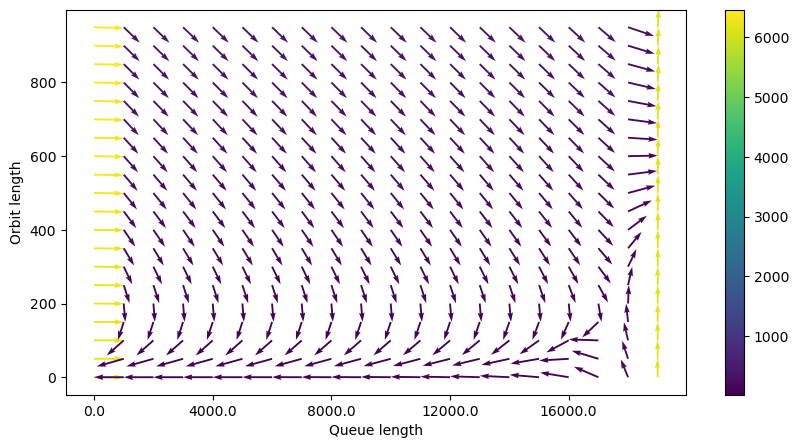

<Figure size 640x480 with 0 Axes>

In [32]:
def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=20000, orbit_size=1000, thread_pool=100)
        src = Source('client', 'insert', 6200, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

visualize(program())

Prediction: One should see a metastable behavior for a queue size around 20000 and orbit around 50.

Unfortunately, these experiments take *a long* time to run --- so we can try to reproduce similar behaviors on a scaled down version of the system.

In [ ]:
def scaled_program():
        # essentially scale down rates by a 100
        
        api = { "insert": Work(.625, [],) }
        server = Server("52", api, qsize=200, orbit_size=10, thread_pool=100)
        src = Source('client', 'insert', 62, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

sp = scaled_program()

In [21]:
basic_stats(sp)


Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 200 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Building CTMC
Program:  Service52 , Number of states =  2000
Computing stationary distribution
Average queue size =  [173.49013472]
[-1.63573590e-13+0.j         -2.67493928e+02+4.29966585j
 -2.67493928e+02-4.29966585j ... -5.95804619e+01+0.j
 -6.07682103e+01+0.35611578j -6.07682103e+01-0.35611578j]
Sorted eigenvalues (real parts): [-1.63573590e-13 -3.75489732e-02 -2.11427572e-01 ... -2.66448107e+02
 -2.67493928e+02 -2.67493928e+02]
Mixing time =  176.93842537109091
Maximum error in solving the linear equation is 4.547473508864641e-12
Maximum error in solving the linear equation is 2.9103830456733704e-11
Expected hitting time to go from high to low mode is 369.6312851974193
Expected hitting time to go from low to high mode is 48.440430457307535


We now try to see how long it takes for a full queue to become small, as the size of the queue increases.

In [24]:
def test_hitting_times_scaled(p):
    qsizes = Parameter(("server", "52", "qsize"), range(500, 2000, 100))
    print("Computing exact recovery times")
    ht = HittingTimeExperiment(p)
    ht.sweep(ParameterList([qsizes]))

test_hitting_times_scaled(sp)

Computing exact recovery times


Running experiment with parameters  {'server': {'52': {'qsize': 500}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 500 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  5000
Maximum error in solving the linear equation is 5.820766091346741e-11
Analysis time =  2.317997932434082  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 600}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 600 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  6000
Maximum error in solving the linear equation is 1.4551915228366852e-10
Analysis time =  3.513237953186035  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 700}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 700 orb

/var/folders/h9/0y8kqv211bj57z57lqrbbvzc0000gq/T/ipykernel_56312/1990129660.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


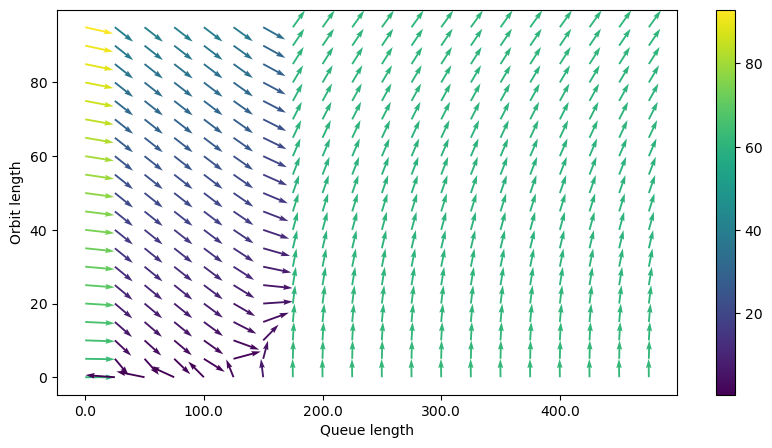

<Figure size 640x480 with 0 Axes>

In [70]:
def scaled_program():
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=500, orbit_size=100, thread_pool=1)
        src = Source('client', 'insert', 62, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

sp = scaled_program()
visualize(sp)

The previous experiment on Hitting times checked how long it takes to go from 98% full queue to 80% full queue. This may not be a very good indicator, we should see how long it takes for a full queue to get back to average queue size in normal mode. The next experiment checks this.

In [64]:
from metafor.analysis.experiment import Experiment


class SweepHittingTimes(Experiment):
    def __init__(self, p: Program, lowfactor: float=0.8, hifactor: float=0.98):
        self.p = p

        self.lowfactor = lowfactor
        self.fullfactor = hifactor

        self.main_color = "#A9A9A9"
        self.fade_color = "#D3D3D3"

    def plot(
            self,
            figure_name: str,
            x_axis: str,
            y_axis: str,
            x_vals,
            hitting_times,
    ):
        plt.rc("font", size=14)
        plt.rcParams["figure.figsize"] = [5, 5]
        plt.rcParams["figure.autolayout"] = True

        plt.figure()  # row 0, col 0
        plt.plot(x_vals, hitting_times, color=self.main_color)

        plt.xlabel(x_axis, fontsize=14)
        plt.ylabel(y_axis, fontsize=14)
        plt.grid("on")
        plt.xlim(min(x_vals), max(x_vals))
        plt.show()
        plt.close()

    def build(self, param) -> Program:
        return self.update(self.p, param)

    def analyze(self, param_setting, p: Program):
        ctmc = p.build()
        pi = ctmc.get_stationary_distribution()
        qavg = ctmc.main_queue_size_average(pi)[0]
        print("Average queue = ", qavg)
        # average = ctmc.set_construction([[0, int(1 * ctmc.thread_pool)]], [[0, ctmc.retry_queue_size]])
        # average = ctmc.set_construction([[0, 100]], [[0, ctmc.retry_queue_size]])
        average = ctmc.set_construction([[0, int(self.lowfactor * qavg)]], [[0, ctmc.retry_queue_size - 1]])
        full = ctmc.set_construction([[int(self.fullfactor * ctmc.main_queue_size), ctmc.main_queue_size - 1]],
                                   [[0, ctmc.retry_queue_size - 1]])
        
        hitting_time = ctmc.get_hitting_time_average(full, average)
        print("Param setting = ", param_setting, " Hitting time = ", hitting_time)
        return [param_setting, hitting_time]

    def show(self, results):
        # print(results)
        PARAMETER = "parameter"
        HITTING_TIME = "Hitting time"
        columns = [PARAMETER, HITTING_TIME]

        pd = pandas.DataFrame(results, columns=columns)

        print(pd)

In [71]:
from metafor.analysis.single_server.latency_experiment import MixingTimeExperiment


def scaled_program():
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=300, orbit_size=20, thread_pool=1)
        src = Source('client', 'insert', 62, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

sp = scaled_program()
# ctmc: SingleServerCTMC = sp.build()
# print("Computing stationary distribution")
# pi = ctmc.get_stationary_distribution()
# q_avg = ctmc.main_queue_size_average(pi)
# print("Average queue size = ", q_avg)

# print("Getting mixing times...", ctmc.get_mixing_time())

# S1 = ctmc.set_construction([[0, int( 0.5 * ctmc.main_queue_size) ]], [[0, ctmc.retry_queue_size-1]])
# S2 = ctmc.set_construction([[int(0.95 * ctmc.main_queue_size), ctmc.main_queue_size-1]], [[0, ctmc.retry_queue_size-1]])
## ht_su = ctmc.get_hitting_time_average(S1, S2)
# ht_us = ctmc.get_hitting_time_average(S2, S1)
# print("Expected hitting time to go from high to low mode is", ht_us)
## print("Expected hitting time to go from low to high mode is", ht_su)

qsizes = Parameter(("server", "52", "qsize"), range(150, 450, 50))
t = SweepHittingTimes(sp, 0.8, 0.98) # how much time does it take a 98% filled queue to get to 80% of the average queue
t.sweep(ParameterList([qsizes]))





Running experiment with parameters  {'server': {'52': {'qsize': 150}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 150 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3000
Average queue =  68.6337215998536
Maximum error in solving the linear equation is 7.275957614183426e-12
Param setting =  {'server': {'52': {'qsize': 150}}}  Hitting time =  79.65363966185136
Analysis time =  12.121623039245605  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 200}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 200 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  4000
Average queue =  181.66141963093943
Maximum error in solving the linear equation is 2.9103830456733704e-11
Param setting =  {'server': {'52': {'qsize': 200}}}  Hitting time =  332.6663

In [72]:
sp = scaled_program()
qsizes = Parameter(("server", "52", "qsize"), range(160, 200, 10))
t = SweepHittingTimes(sp, 0.8, 0.98) # how much time does it take a 98% filled queue to get to 80% of the average queue
t.sweep(ParameterList([qsizes]))



Running experiment with parameters  {'server': {'52': {'qsize': 160}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 160 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3200
Average queue =  78.88549931006423
Maximum error in solving the linear equation is 7.275957614183426e-12
Param setting =  {'server': {'52': {'qsize': 160}}}  Hitting time =  103.06643336372065
Analysis time =  14.226533889770508  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 170}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 170 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3400
Average queue =  105.61681351891208
Maximum error in solving the linear equation is 1.4551915228366852e-11
Param setting =  {'server': {'52': {'qsize': 170}}}  Hitting time =  180.77

In [73]:
# Mixing time is an approximate measure of the hitting time... this is useful when the hitting time is hard to compute
# because the linear system does not converge quickly.
# Mixing time computation needs finding the second largest eigenvalue of the matrix
sp = scaled_program()
qsizes = Parameter(("server", "52", "qsize"), range(160, 200, 10))

t = MixingTimeExperiment(sp)
t.sweep(ParameterList([qsizes]))




Running experiment with parameters  {'server': {'52': {'qsize': 160}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 160 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3200
[-2.59347841e+02+0.j          7.00859809e-13+0.j
 -2.57845837e+02+0.02564745j ... -1.66452788e+01+0.j
 -1.66416038e+01+0.j         -1.16234472e+01+0.j        ]
Sorted eigenvalues (real parts): [ 7.00859809e-13 -1.67546955e-02 -8.10099441e-02 ... -2.57845837e+02
 -2.57845837e+02 -2.59347841e+02]
Analysis time =  18.808279037475586  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 170}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 170 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3400
[-262.59609304+0.j         -260.93278686+0.j
 -259.6104208 +0.06388265j ...  -2